In [39]:
import pandas as pd

with open('../data/DatasetCleaned.csv', 'r') as f:
    data = pd.read_csv(f)

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import KFold, LeaveOneOut, cross_val_score

import pandas as pd
from tqdm import tqdm
import numpy as np

def RegrLasso(Y_data:pd.Series, X_data:pd.DataFrame, alpha, #Function imported from another project of mine, see https://github.com/Interorm/IMF-Bias---Hausarbeit
              display:bool=True, iter:int=100000):
    
    dependent_var = Y_data.name

    Y = Y_data.copy().values
    X = X_data.copy().values.reshape(-1, X_data.shape[1])
    feature_names = X_data.columns
    
    if display:
        coefs_all = [] 
        mse = []
        for a in tqdm(alpha): 
            lasso = Lasso(alpha=a,  max_iter=1000000, tol=1e-4)
            lasso.fit(X, Y) 
            coefs_all.append(lasso.coef_) 
            mse_this = ( -cross_val_score(lasso, X, Y, scoring="neg_mean_squared_error", cv=KFold()) )
            mse_this = np.mean(mse_this)
            mse.append(mse_this)
        coefs_all = np.array(coefs_all)
    

    lasso_cv = LassoCV(alphas=alpha, cv=KFold(), max_iter=100000)
    lasso_cv.fit(X, Y)

    best_alpha = lasso_cv.alpha_
    print("Best alpha:", best_alpha)

    
    print(f"R²: {lasso_cv.score(X,Y)}")

    coefs = []
    for i, featuer in enumerate(feature_names):
        coef = lasso_cv.coef_[i]
        if coef == 0: continue
        coefs.append({"Regressor": featuer, "Coefficient": coef})
    coefs = sorted(coefs, key = lambda x: x["Coefficient"], reverse=True)
    for coef in coefs: 
        c = round(coef["Coefficient"], 4)
        r = coef["Regressor"]
        if any(True for fixed in ["Region", "Country"] if fixed in r): continue
        print(f"{r}: {c}")

    if display: 
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,16))
        
        # Top Left axis: MSE
        ax1.plot(alpha, mse, color="red", linewidth=2, label="CV MSE")
        ax1.set_xlabel("Lambda")
        ax1.set_xscale("log")
        ax1.set_ylabel("Mean Squared Error")
        ax1.set_title('Mean Squared Error')
        ax1.axvline(x = best_alpha, color = 'black', linestyle = '--')
        #ax1.tick_params(axis="y", labelcolor="red")

        # Top Right axis: Coefficients
        colors = sns.color_palette("Paired", len(feature_names))
        for i, name in enumerate(feature_names):
            if any(True for fixed in ["Region", "Country"] if fixed in name): continue
            ax2.plot(alpha, coefs_all[:, i], label=name, color=colors[i])
        ax2.set_xlabel("Lambda")
        ax2.set_xscale("log")
        ax2.set_ylabel("Coefficient values")
        ax2.set_title("Lasso Coefficients vs Lambda")
        ax2.axvline(x = best_alpha, color = 'black', linestyle = '--')
        ax2.grid(True)

        # Bottom Left: Predcition vs. Truth
        Y_predicted = pd.DataFrame({'Predicted':lasso_cv.predict(X), 'True':Y})
        Y_predicted = Y_predicted.sort_values(by='True')
        ax3.plot( Y_predicted['True'], Y_predicted['Predicted'], color='lightblue', label='Predicted Values' )
        ax3.plot( Y_predicted['True'], Y_predicted['True'], color = 'red' )
        ax3.set_xlabel(f'Actual {dependent_var}')
        ax3.set_ylabel(f'Predicted {dependent_var}')
        ax3.set_title('Prediction vs. Reality for Best Model')
        ax3.grid(False)

        # Bottom Right: Number of relevant Coef
        ax4.plot(alpha, np.count_nonzero(coefs_all, axis=1), color='red', label = 'Non-Zero Coefficients')
        ax4.set_xlabel("Lambda")
        ax4.set_xscale("log")
        ax4.set_ylabel("# Non-Zero Coefficients")
        ax4.set_title("Non-Zero Coefficients")
        ax4.axvline(x = best_alpha, color = 'black', linestyle = '--')
        ax4.grid(True)


        plt.tight_layout()
        plt.show()

    return lasso_cv


In [41]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer

Y = data['SalePrice']


X = data.copy().drop(columns=['YearBuilt', 'YearRemodAdd']) #Remove Years, change for Age
X['YrSold'] = X['YrSold'].astype(str) #make YrSold Categorical to be intercept

def Scale(col:pd.Series, log:bool=True) -> pd.Series:
    #if log: col = np.log(col)
    #col = col.apply(lambda x: (x - col.mean()) / col.std())
    return col

X_prep = pd.DataFrame(index=X.index)
X_types = X.dtypes.to_dict()
scaler = PowerTransformer(method='yeo-johnson')

for col, t in X_types.items():
    if col in ['SalePrice','Unnamed: 0']: continue

    if t in ['int', 'float']:
        X_prep[col] = scaler.fit_transform(pd.DataFrame(X[col]))
        #add script for rankings?
        continue

    if t == 'object': 
        new_col = pd.get_dummies(X[col], prefix=col, drop_first=True, dtype=int)
        for dummy_col in new_col.columns:
            X_prep[dummy_col] = new_col[dummy_col]
        continue

    print(f'Type \"{t}\" not in standard types!')

X = X_prep

C:\Users\karli\AppData\Local\Temp\ipykernel_43192\1231136589.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_prep[dummy_col] = new_col[dummy_col]
C:\Users\karli\AppData\Local\Temp\ipykernel_43192\1231136589.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_prep[dummy_col] = new_col[dummy_col]
C:\Users\karli\AppData\Local\Temp\ipykernel_43192\1231136589.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider join

100%|██████████| 100/100 [00:30<00:00,  3.29it/s]


Best alpha: 155.56761439304722
R²: 0.8703600855264364
Neighborhood_NoRidge: 49117.8765
Neighborhood_StoneBr: 44357.3645
Neighborhood_NridgHt: 31754.712
Exterior2nd_ImStucc: 20545.0381
OverallQual: 15934.5064
Neighborhood_Crawfor: 14938.5502
Exterior1st_BrkFace: 14567.4269
SaleType_New: 14188.243
1stFlrSF: 13817.836
Neighborhood_Somerst: 12640.146
BsmtQual: 11581.3932
Condition1_Norm: 10120.3924
2ndFlrSF: 9570.2523
RoofMatl_WdShngl: 8984.722
GarageCars: 8633.0951
TotRmsAbvGrd: 8330.3452
MSSubClass_2-STORY 1946 & NEWER: 8300.3325
LotArea: 8026.0553
Exterior2nd_CmentBd: 7344.1214
Neighborhood_BrkSide: 6835.0275
MSSubClass_1-STORY 1946 & NEWER ALL STYLES: 6667.487
GarageType_BuiltIn: 6402.8367
GarageQual: 5999.096
RoofStyle_Hip: 5744.3949
Bathrooms: 5726.0408
BsmtFinSF1: 5116.7818
OverallCond: 4645.8059
Neighborhood_BrDale: 4059.9811
BsmtExposure: 3593.2067
TotalBsmtSF: 3530.1146
LandSlope_Mod: 3511.9791
KitchenQual: 3289.2427
Fireplaces: 2892.4716
BsmtBathrooms: 2676.9274
SaleCondition_No

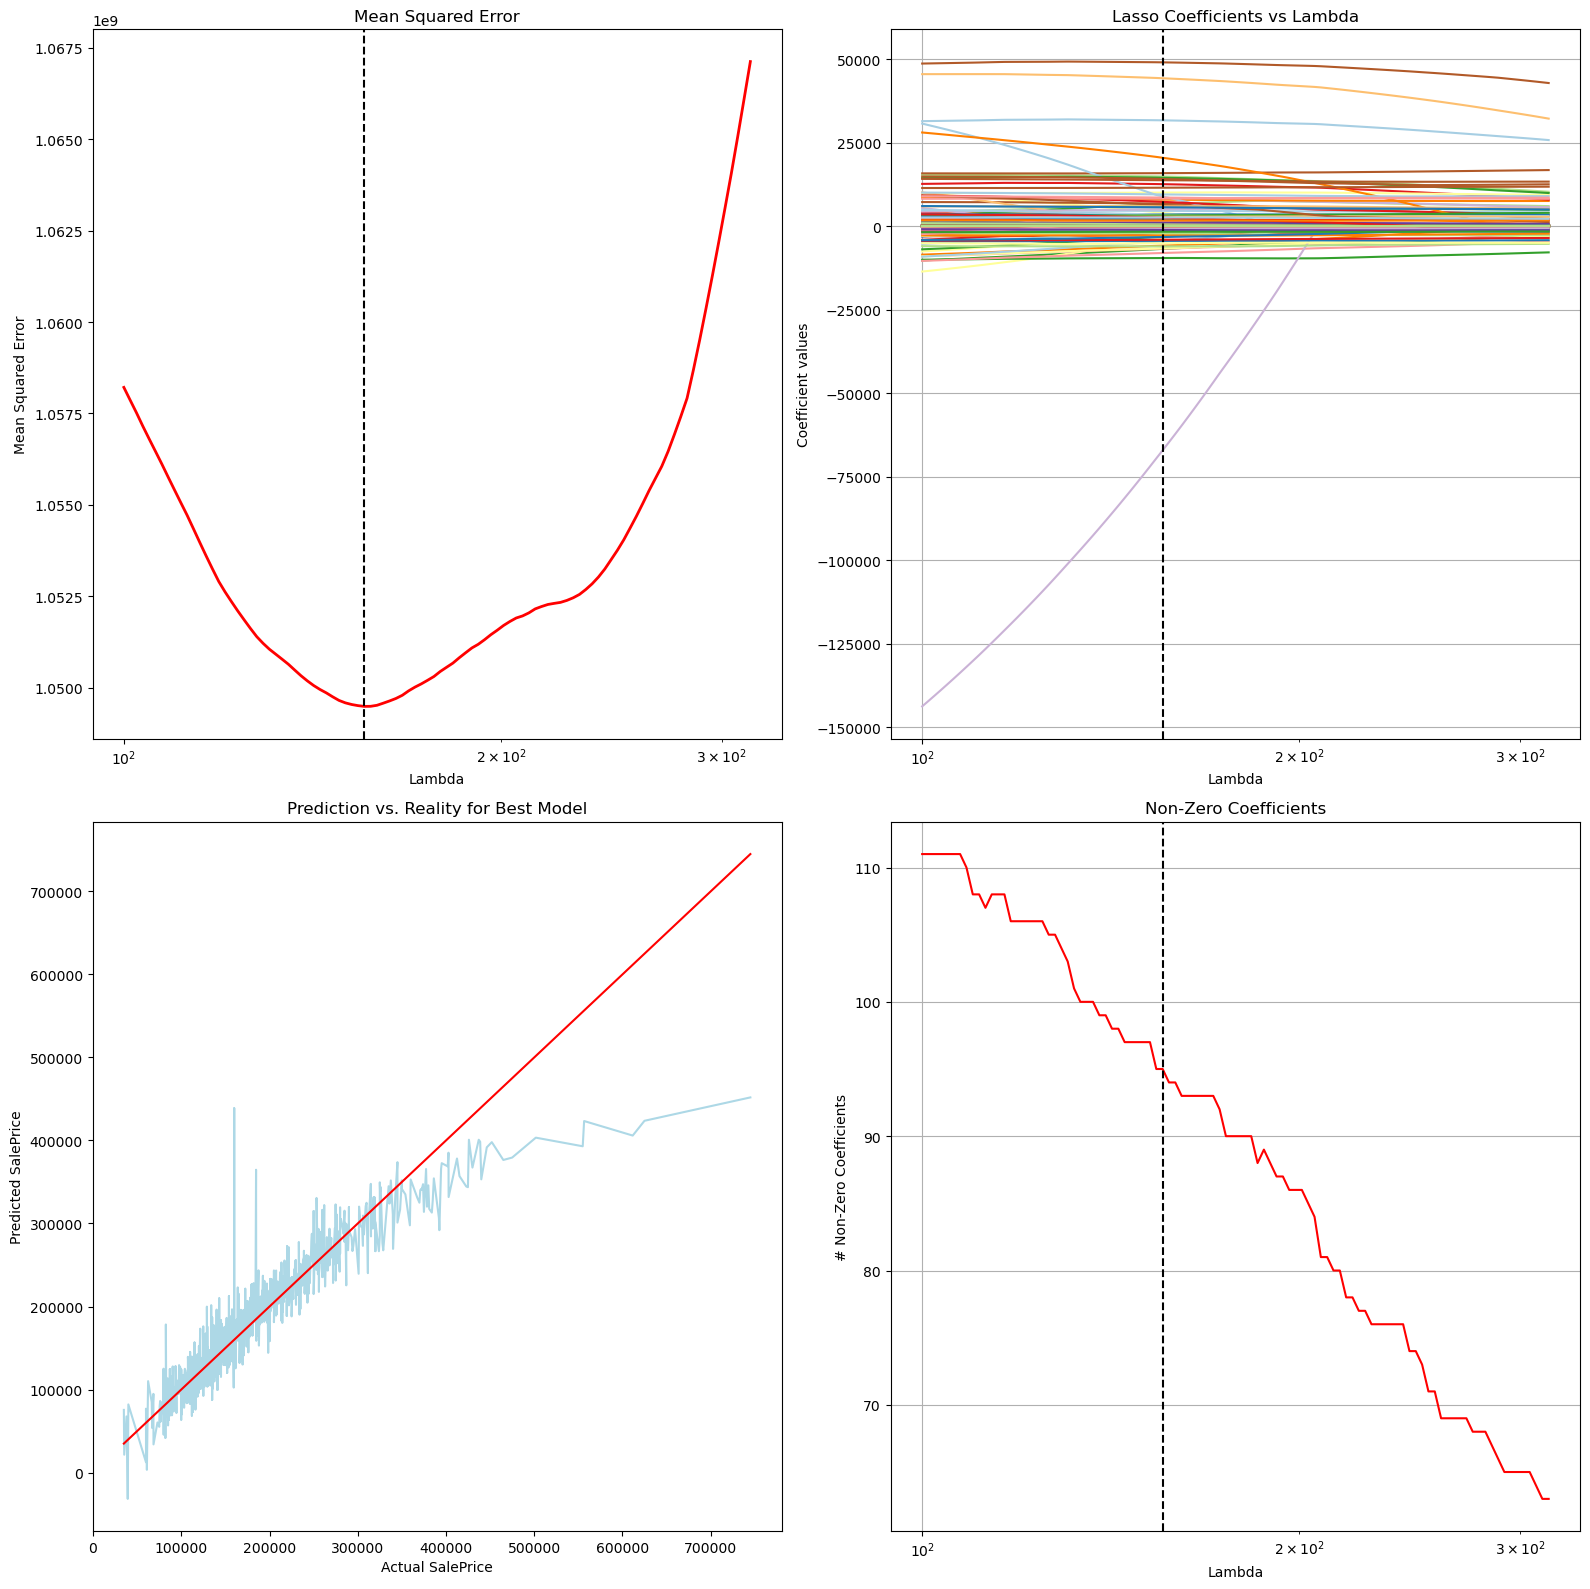

In [42]:
lasso_model = RegrLasso(Y, X, alpha=np.logspace(2,2.5,100))

In [45]:
import pickle

with open('../models/Lasso.sav', 'wb') as f:
    pickle.dump(lasso_model, f)